In [ ]:
pip install bayesian-optimization

In [ ]:
pip install xgboost

In [ ]:
import numpy as np 
import pandas as pd 
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from bayes_opt import BayesianOptimization
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve

from sklearn import metrics
from sklearn import preprocessing
import xgboost as xgb

# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

#Timer
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Time taken for Modeling: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%time

folder_path = './drive/MyDrive/data/'
print('Loading data...')

train_identity = pd.read_csv(f'{folder_path}train_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_identity!')

train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_transaction!')

test_identity = pd.read_csv(f'{folder_path}test_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_identity!')

test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_transaction!')

sub = pd.read_csv(f'{folder_path}sample_submission.csv')
print('\tSuccessfully loaded sample_submission!')

print('Data was successfully loaded!\n')

Loading data...
	Successfully loaded train_identity!
	Successfully loaded train_transaction!
	Successfully loaded test_identity!
	Successfully loaded test_transaction!
	Successfully loaded sample_submission!
Data was successfully loaded!

CPU times: user 29.2 s, sys: 3.95 s, total: 33.1 s
Wall time: 42.7 s


In [ ]:
%%time
# merge to data
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 7.09 s, sys: 3.41 s, total: 10.5 s
Wall time: 10.6 s


In [ ]:
# GPreda, missing data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
del train_transaction, train_identity, test_transaction, test_identity

In [ ]:
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

In [ ]:
train_df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [ ]:
# Label Encoding
for f in train_df.columns:
    if  train_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))  
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [ ]:
features = list(train_df)
features.remove('isFraud')
print(features)
target = 'isFraud'

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',

XGBoost GPU modeling...

fold 1
[0]	validation_0-auc:0.845279	validation_0-logloss:0.529687
[100]	validation_0-auc:0.965268	validation_0-logloss:0.052311
[200]	validation_0-auc:0.969114	validation_0-logloss:0.04897
[300]	validation_0-auc:0.970059	validation_0-logloss:0.049629
[400]	validation_0-auc:0.970554	validation_0-logloss:0.05112
[500]	validation_0-auc:0.970737	validation_0-logloss:0.052679
[600]	validation_0-auc:0.971027	validation_0-logloss:0.053802
[700]	validation_0-auc:0.970921	validation_0-logloss:0.054981
[800]	validation_0-auc:0.970887	validation_0-logloss:0.056057
[900]	validation_0-auc:0.970794	validation_0-logloss:0.056945
[999]	validation_0-auc:0.970783	validation_0-logloss:0.057601
OK
OK
OK
OK
OK
OK

fold 2
[0]	validation_0-auc:0.836153	validation_0-logloss:0.529948
[100]	validation_0-auc:0.967061	validation_0-logloss:0.051173
[200]	validation_0-auc:0.970704	validation_0-logloss:0.048071
[300]	validation_0-auc:0.971923	validation_0-logloss:0.048118
[400]	validation_0

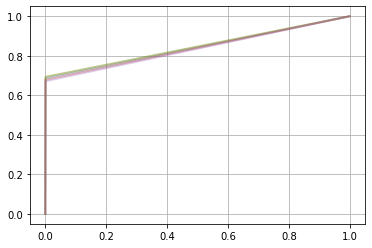

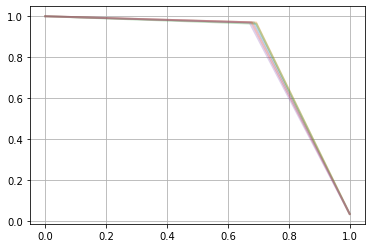

In [ ]:
print('XGBoost GPU modeling...')
start_time = timer(None)
plt.rcParams["axes.grid"] = True

nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train_df, train_df.isFraud.values):
    print("\nfold {}".format(i)) 
    clf = xgb.XGBClassifier( 
        n_estimators=1000,
        max_depth=12, 
        learning_rate=0.2, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric=['auc', 'logloss'],
        tree_method='gpu_hist' 
    )

    clf.fit(train_df.iloc[train_idx][features].values,
                train_df.iloc[train_idx][target].values, 
                eval_set=[(train_df.iloc[valid_idx][features].values,
                           train_df.iloc[valid_idx]['isFraud'].values)],
                verbose=100)
    
    print("OK")

    oof[valid_idx]  = clf.predict(train_df.iloc[valid_idx][features].values)   
    oof[valid_idx]  = np.exp(oof[valid_idx]) / (1 + np.exp(oof[valid_idx]))
    
    print("OK")
    
    # Scores 
    roc_aucs.append(roc_auc_score(train_df.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    print("OK")

    # Roc curve by fold
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))

    print("OK")

    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    print("OK")

    # Features imp
    """
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.get_feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    """
    clf.save_model('CBmodel' + str(i) + '.json')

    print("OK")
# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores)))

In [ ]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

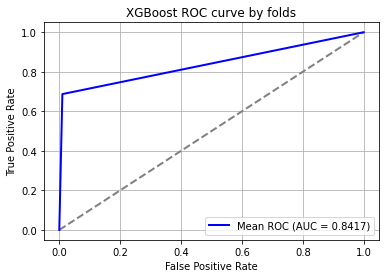

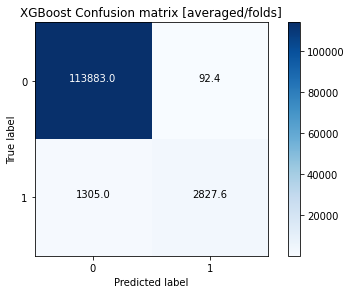

In [ ]:
#ROC
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC curve by folds')
plt.legend(loc="lower right")

# XGBoost maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'XGBoost Confusion matrix [averaged/folds]')
# Timer end  